<a href="https://colab.research.google.com/github/irshandyaditya/machine_learning/blob/main/P10/Praktikum_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'I thought the movie was a poor documentary. Nothing of substance was discussed. It seemed to cheapen the ideas and did not provide anything new. The film lacked wonder or romance or anything that would really drive one to science. Most scientists appeared "stereotyped" and sometimes weird. A woman said that her awards didn\'t matter a whole lot, only children that were helped. She said that after a 10 minute scene where she explained all her awards. Playing "humble scientist", are we? "I have equations dancing in my head," another said. I don\'t see how that explains anything to us. It hasn\'t covered significant effects of science on our culture. Politics of science were barely touched.<br /><br />Not a bad flick for a 10-14 year-olds. Other than that, I felt it was boring and unrevealing.<br /><br />4/10'
 b'Almost too well done... "John Carpenter\'s Vampires" was entertaining, a solid piece of popcorn-entertainment with a budget small enough not to be overrun by special e

### **Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 199,   2, ...,   0,   0,   0],
       [210, 100,  74, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I thought the movie was a poor documentary. Nothing of substance was discussed. It seemed to cheapen the ideas and did not provide anything new. The film lacked wonder or romance or anything that would really drive one to science. Most scientists appeared "stereotyped" and sometimes weird. A woman said that her awards didn\'t matter a whole lot, only children that were helped. She said that after a 10 minute scene where she explained all her awards. Playing "humble scientist", are we? "I have equations dancing in my head," another said. I don\'t see how that explains anything to us. It hasn\'t covered significant effects of science on our culture. Politics of science were barely touched.<br /><br />Not a bad flick for a 10-14 year-olds. Other than that, I felt it was boring and unrevealing.<br /><br />4/10'
Round-trip:  i thought the movie was a poor documentary nothing of [UNK] was [UNK] it seemed to [UNK] the ideas and did not [UNK] anything new the film [UNK] wonder or 

### **Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ['The movie was cool. The animation and the graphics ',
               'were out of this world. I would recommend this movie.']

# Lakukan prediksi
text_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(text_tensor)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.00843011]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
text_padding = padding + " " .join(sample_text)
text_padding_convert = tf.convert_to_tensor([text_padding])
predictions = model.predict(text_padding_convert)
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
[0.02091344]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 57ms/step - accuracy: 0.5042 - loss: 0.6850 - val_accuracy: 0.6484 - val_loss: 0.5495
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.7881 - loss: 0.4407 - val_accuracy: 0.8401 - val_loss: 0.3590
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8506 - loss: 0.3450 - val_accuracy: 0.8656 - val_loss: 0.3380
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.8568 - loss: 0.3286 - val_accuracy: 0.8594 - val_loss: 0.3421
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.8630 - loss: 0.3168 - val_accuracy: 0.8448 - val_loss: 0.3254
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8641 - loss: 0.3126 - val_accuracy: 0.8578 - val_loss: 0.3416
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8692 - loss: 0.3029 - val_accuracy: 0.8589 - val_loss: 0.3048
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.8682 - loss: 0.3026 - 

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8480 - loss: 0.3198
Test Loss: 0.31899189949035645
Test Accuracy: 0.8473600149154663


(0.0, 0.6778376698493958)

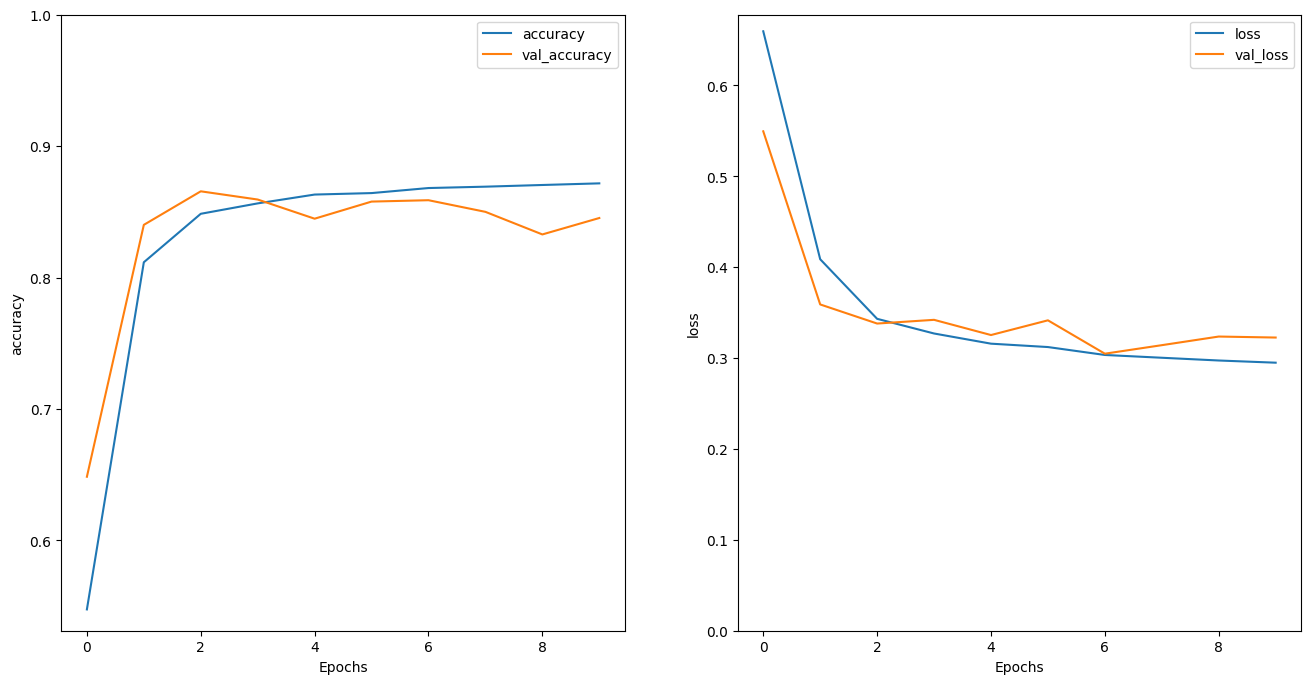

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_text = ['The movie was cool. The animation and the graphics ',
              'were out of this world. I would recommend this movie.']
text_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(text_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


# **Stack two or more LSTM layers**

In [22]:
model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
       optimizer=tf.keras.optimizers.Adam(1e-4),
       metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
          validation_data=test_dataset,
          validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.5112 - loss: 0.6851 - val_accuracy: 0.8005 - val_loss: 0.4821
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.8026 - loss: 0.4389 - val_accuracy: 0.8615 - val_loss: 0.3538
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8498 - loss: 0.3502 - val_accuracy: 0.8672 - val_loss: 0.3092
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.8535 - loss: 0.3377 - val_accuracy: 0.8396 - val_loss: 0.3362
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8599 - loss: 0.3262 - val_accuracy: 0.8583 - val_loss: 0.3354
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8666 - loss: 0.3085 - val_accuracy: 0.8495 - val_loss: 0.3305
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8663 - loss: 0.3104 - val_accuracy: 0.8609 - val_loss: 0.3106
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - accuracy: 0.8655 - loss: 0

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8619 - loss: 0.3309
Test Loss: 0.3280455768108368
Test Accuracy: 0.8622400164604187


In [28]:
# predict on a sample text without padding.

sample_text = ['The movie was cool. The animation and the graphics ',
              'were out of this world. I would recommend this movie.']
text_tensor = tf.convert_to_tensor(sample_text)
predictions = model.predict(text_tensor)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[ 0.5859819 ]
 [-0.45270044]]


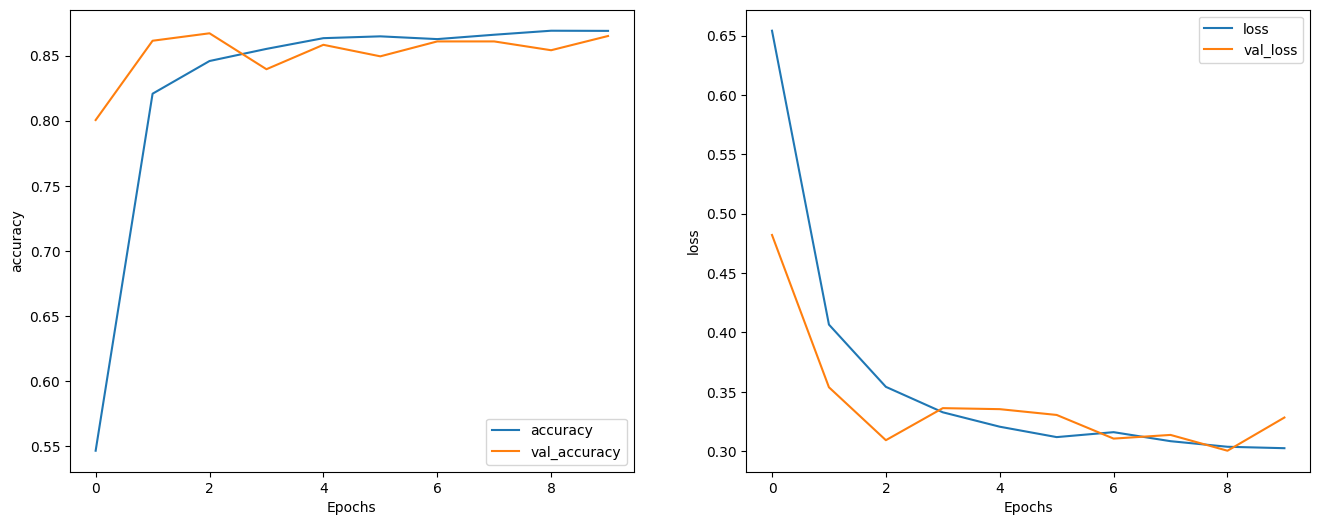

In [29]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')